In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import warnings
import anndata
from matplotlib import pyplot as plt

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [2]:
pbmc = sc.read_h5ad('/media/MPEdge16/MM137/sc/py/py_out/pbmc/pbmc_final.h5ad')

In [3]:
sim = sc.read_h5ad('/media/MPEdge16/MM137/sc/py/py_out/pbmc/pbmc_myeloid_platelet_int_sim.h5ad') # take sim MPA
myl = sc.read_h5ad('/media/MPEdge16/MM137/sc/py/py_out/pbmc/pbmc_myeloid.h5ad') # integrated myeloid (singlet) object
dbl = sc.read_h5ad('/media/MPEdge16/MM137/sc/py/py_out/pbmc/pbmc_myeloid_platelet_int_dbl.h5ad') # contains soup, solo doublets

In [4]:
sim_mpa = sim[sim.obs['droplet_type']=='MPA_sim']

In [5]:
myl.obs['bubble_type'] = myl.obs['merged_type']
sim_mpa.obs['bubble_type'] = 'sMPA'

In [6]:
plat = pbmc[pbmc.obs['cell_type']=='Platelet']
plat.obs['bubble_type'] = 'Platelet'

In [7]:
solo_dbl = dbl[dbl.obs['solo_prediction']=='doublet']
soup_dbl = dbl[dbl.obs['solo_prediction']=='souporcell_doublet']

In [8]:
solo_dbl.obs['bubble_type'] = 'solo'
soup_dbl.obs['bubble_type'] = 'souporcell'

In [9]:
assert np.all(myl.layers['counts'].data == myl.layers['counts'].data.astype(np.int32))
assert np.all(sim_mpa.layers['counts'].data == sim_mpa.layers['counts'].data.astype(np.int32))
assert np.all(plat.layers['counts'].data == plat.layers['counts'].data.astype(np.int32))
assert np.all(soup_dbl.layers['counts'].data == soup_dbl.layers['counts'].data.astype(np.int32))
assert np.all(solo_dbl.layers['counts'].data == solo_dbl.layers['counts'].data.astype(np.int32))
ad1 = anndata.AnnData(X = myl.layers['counts'].copy(), var = myl.var, obs = myl.obs)
ad2 = anndata.AnnData(X = sim_mpa.layers['counts'].copy(), var = sim_mpa.var, obs = sim_mpa.obs)
ad3 = anndata.AnnData(X = plat.layers['counts'].copy(), var = plat.var, obs = plat.obs)
ad4 = anndata.AnnData(X = soup_dbl.layers['counts'].copy(), var = soup_dbl.var, obs = soup_dbl.obs)
ad5 = anndata.AnnData(X = solo_dbl.layers['counts'].copy(), var = solo_dbl.var, obs = solo_dbl.obs)
adata = sc.concat([ad1, ad2, ad3, ad4, ad5])

In [10]:
assert np.all(adata.X.data == adata.X.data.astype(np.int32))
adata.layers['counts'] = adata.X.copy()

In [11]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [12]:
for types in adata.obs.bubble_type.unique():
    print("'"+types+"': '', #")

'CD14 Mono': '', #
'CD16 Mono': '', #
'M-platelet': '', #
'cDC2': '', #
'pDC': '', #
'cDC1': '', #
'sMPA': '', #
'Platelet': '', #
'souporcell': '', #
'solo': '', #


In [13]:
rename_types = {
'CD14 Mono': 'cMono', #
'CD16 Mono': 'nMono', #
'M-platelet': 'MPA', #
'cDC2': 'cDC2', #
'pDC': 'pDC', #
'cDC1': 'cDC1', #
'sMPA': 'SimMPA', #
'Platelet': 'Platelet', # 
'souporcell': 'Doublet', #
'solo': 'Doublet', #
}

In [14]:
adata.obs['mapped_names'] = adata.obs['bubble_type'].map(rename_types)
type_order = ['Platelet','SimMPA','MPA','cMono','nMono','cDC1','cDC2','pDC','Doublet']
adata.obs['mapped_names'] = adata.obs['mapped_names'].astype(pd.CategoricalDtype(categories=type_order, ordered=True))

In [16]:
#sc.tl.rank_genes_groups(adata, groupby = 'mapped_names', method = 'logreg', key_added = 'logreg')

In [17]:
#plt.rcParams['figure.figsize'] = [10, 10]
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key = "logreg", fontsize=25)

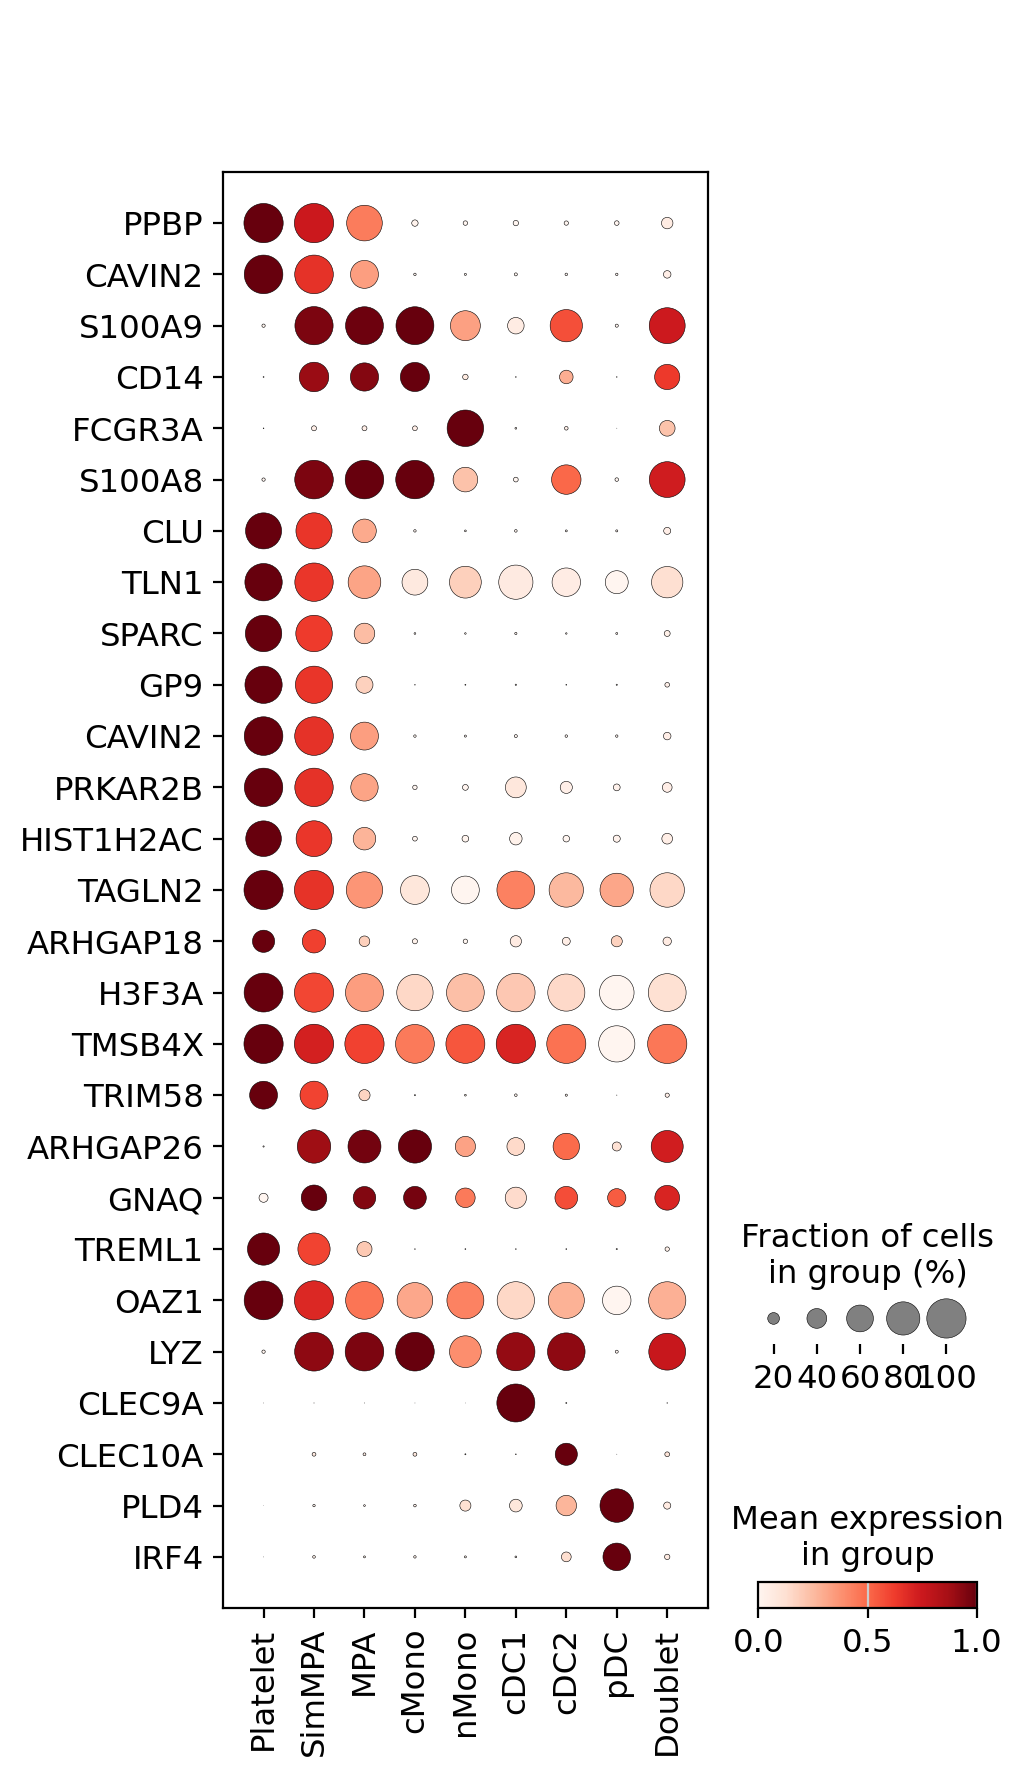

In [18]:
# remove: CCR2, SLC9A1, SLC5A2, F2RL3, IL1B, IL1R1, CD40LG, CD40, CX3CR1, F3
# add: PPBP, CAVIN2, S100A9,CD14, CD16, S100A8
sc.set_figure_params(dpi=100)
sc.pl.dotplot(adata, ['PPBP','CAVIN2','S100A9','CD14','FCGR3A','S100A8','CLU','TLN1','SPARC','GP9','CAVIN2','PRKAR2B','HIST1H2AC','TAGLN2','ARHGAP18','H3F3A','TMSB4X','TRIM58','ARHGAP26','GNAQ','TREML1','OAZ1','LYZ','CLEC9A','CLEC10A','PLD4','IRF4'], 
              groupby = 'mapped_names', swap_axes = True, use_raw = False, standard_scale = 'var', dendrogram = False)

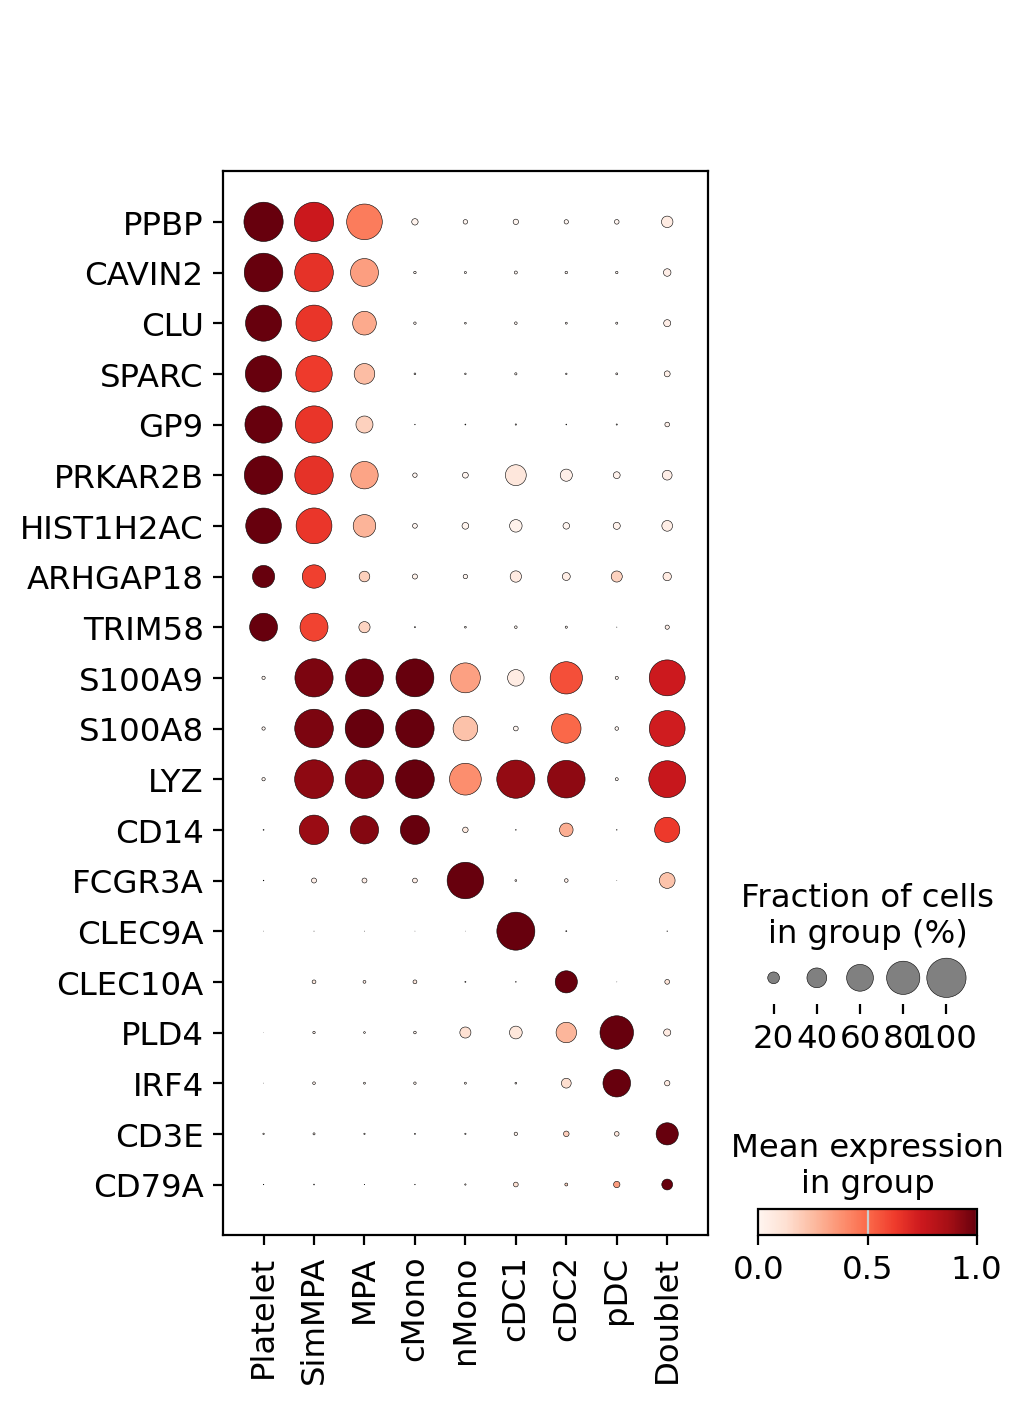

In [19]:
# remove: CCR2, SLC9A1, SLC5A2, F2RL3, IL1B, IL1R1, CD40LG, CD40, CX3CR1, F3
# add: PPBP, CAVIN2, S100A9,CD14, CD16, S100A8
sc.settings.figdir = '/media/WD24/sadie10x/rna/figure/'
sc.set_figure_params(dpi=100)
sc.pl.dotplot(adata, ['PPBP','CAVIN2','CLU','SPARC','GP9','PRKAR2B','HIST1H2AC','ARHGAP18','TRIM58','S100A9','S100A8','LYZ','CD14','FCGR3A','CLEC9A','CLEC10A','PLD4','IRF4','CD3E','CD79A'], 
              groupby = 'mapped_names', swap_axes = True, use_raw = False, standard_scale = 'var', dendrogram = False, save = 'bubble_doublets_21APR2025.pdf')

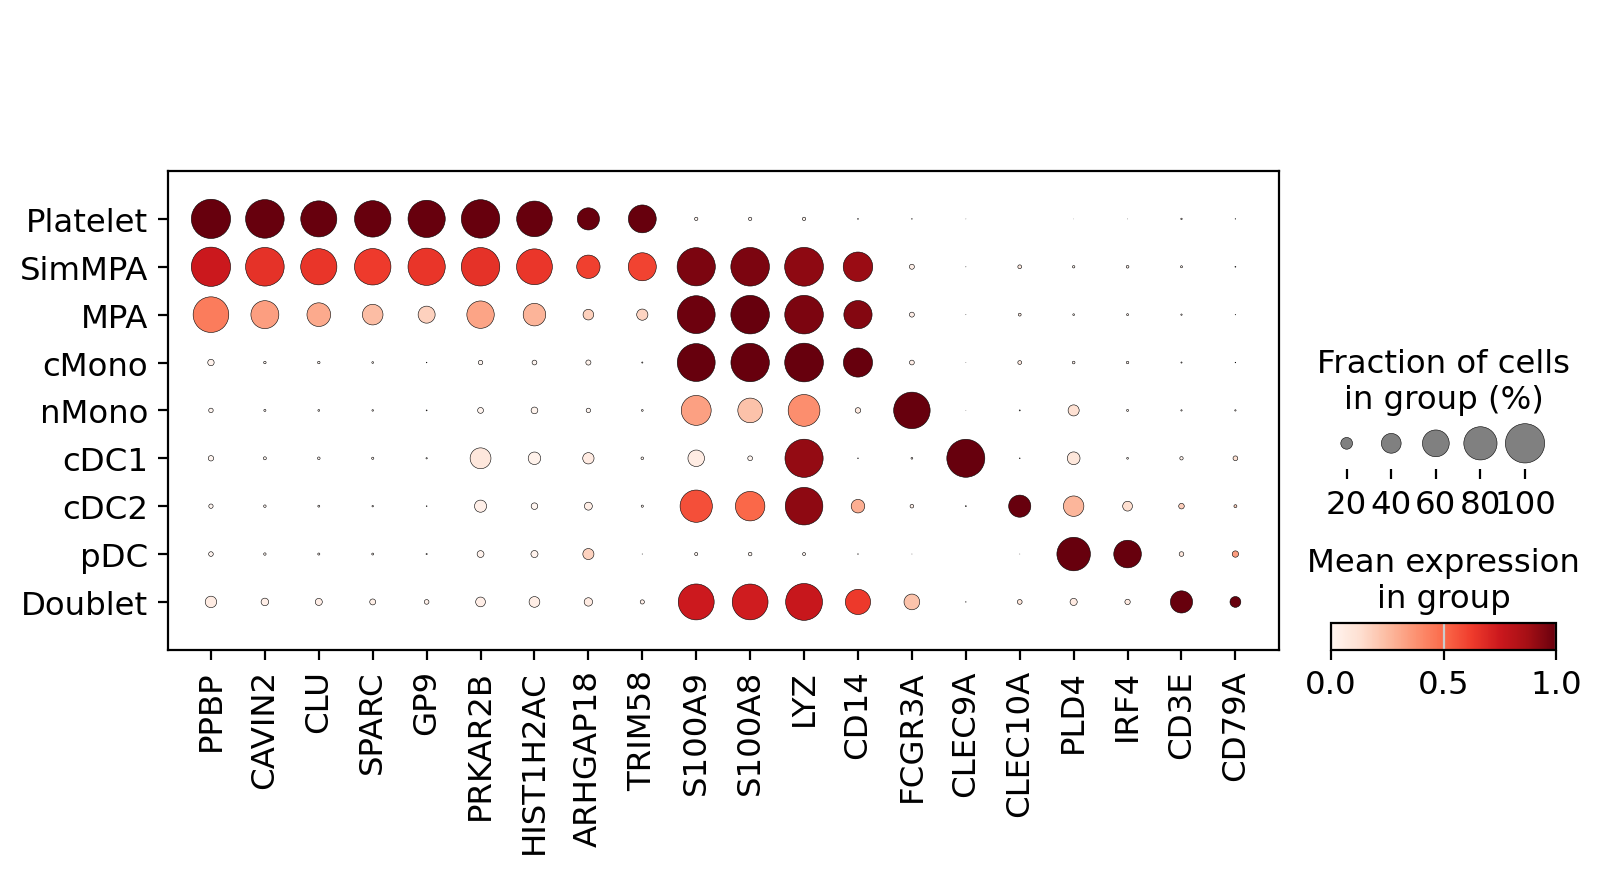

In [20]:
# remove: CCR2, SLC9A1, SLC5A2, F2RL3, IL1B, IL1R1, CD40LG, CD40, CX3CR1, F3
# add: PPBP, CAVIN2, S100A9,CD14, CD16, S100A8
sc.settings.figdir = '/media/WD24/sadie10x/rna/figure/'
sc.set_figure_params(dpi=100)
sc.pl.dotplot(adata, ['PPBP','CAVIN2','CLU','SPARC','GP9','PRKAR2B','HIST1H2AC','ARHGAP18','TRIM58','S100A9','S100A8','LYZ','CD14','FCGR3A','CLEC9A','CLEC10A','PLD4','IRF4','CD3E','CD79A'], 
              groupby = 'mapped_names', swap_axes = False, use_raw = False, standard_scale = 'var', dendrogram = False, save = 'bubble_doublets_21APR2025.pdf')

         Falling back to preprocessing with `sc.pp.pca` and default params.


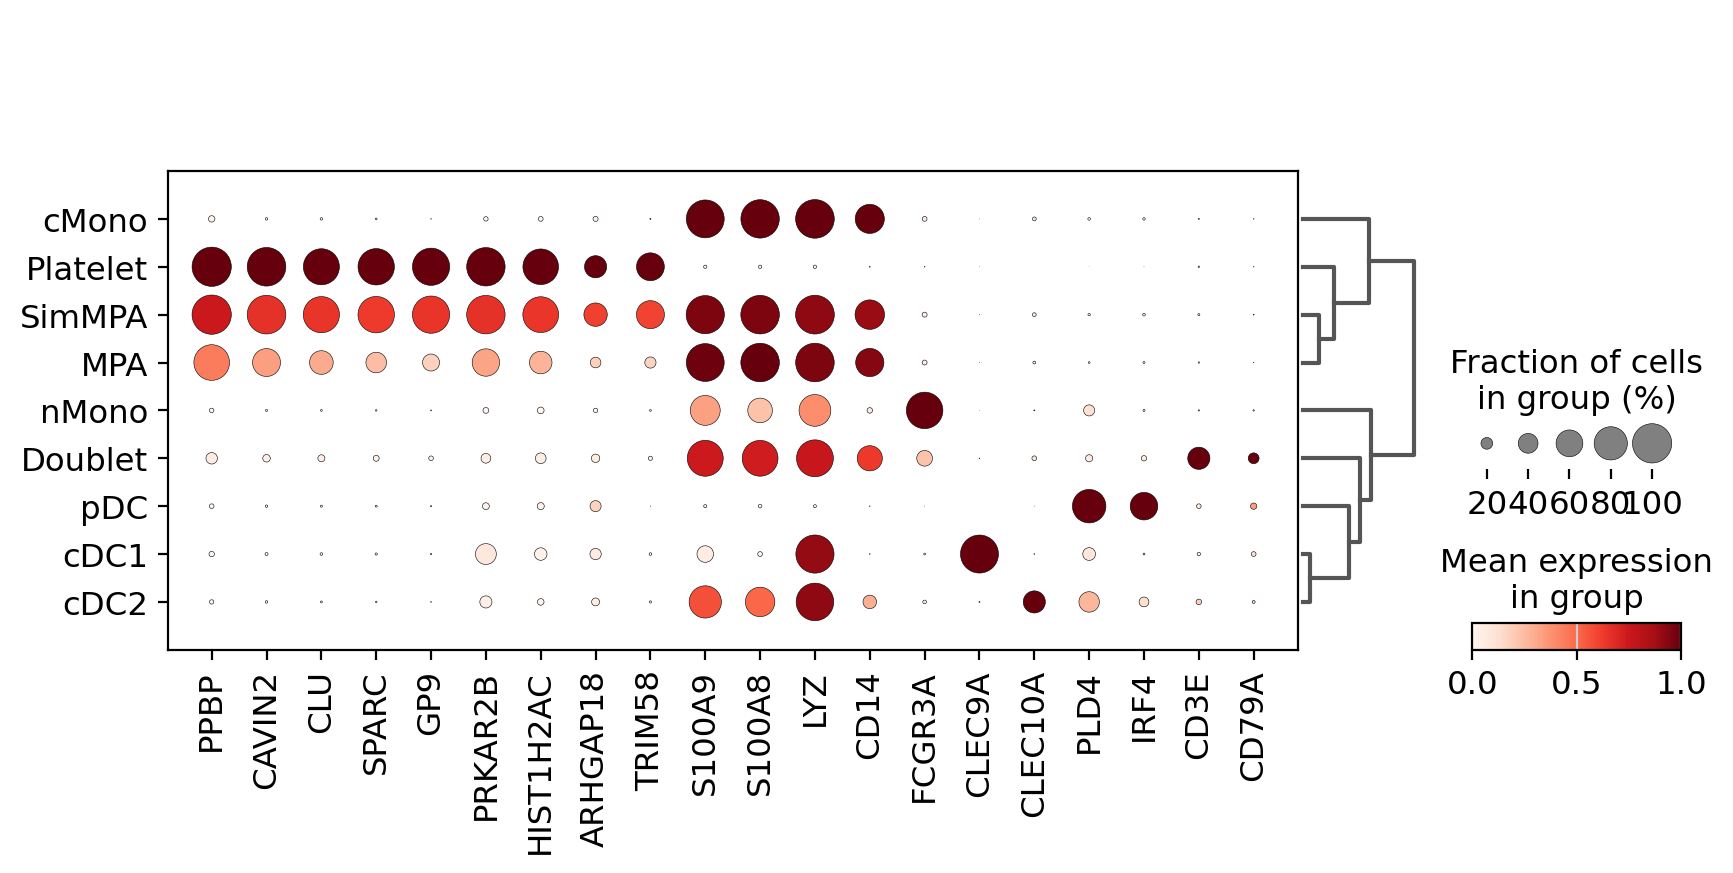

In [21]:
# remove: CCR2, SLC9A1, SLC5A2, F2RL3, IL1B, IL1R1, CD40LG, CD40, CX3CR1, F3
# add: PPBP, CAVIN2, S100A9,CD14, CD16, S100A8
sc.settings.figdir = '/media/WD24/sadie10x/rna/figure/'
sc.set_figure_params(dpi=100)
sc.pl.dotplot(adata, ['PPBP','CAVIN2','CLU','SPARC','GP9','PRKAR2B','HIST1H2AC','ARHGAP18','TRIM58','S100A9','S100A8','LYZ','CD14','FCGR3A','CLEC9A','CLEC10A','PLD4','IRF4','CD3E','CD79A'], 
              groupby = 'mapped_names', swap_axes = False, use_raw = False, standard_scale = 'var', dendrogram = True, save = 'bubble_doublets_dendro_21APR2025.pdf')